# **1-Checking GPU**

In [2]:
!nvidia-smi -L


GPU 0: NVIDIA GeForce GTX 1650 (UUID: GPU-53a3e216-6706-e120-b818-40b8c0b04c26)


# **2- Import Libraries**

In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
tf.__version__

'2.15.0'

# **3- Import Functions from helping function**

In [5]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

# **4- import dataset**

In [6]:
#How many images/classes are there?
walk_through_dir("../../output_1")

There are 3 directories and 0 images in '../../output_1'.
There are 37 directories and 0 images in '../../output_1\test'.
There are 0 directories and 63 images in '../../output_1\test\Apple__black_rot'.
There are 0 directories and 166 images in '../../output_1\test\Apple__healthy'.
There are 0 directories and 37 images in '../../output_1\test\Apple__rust'.
There are 0 directories and 70 images in '../../output_1\test\Apple__scab'.
There are 0 directories and 50 images in '../../output_1\test\Cassava__bacterial_blight'.
There are 0 directories and 57 images in '../../output_1\test\Cassava__brown_streak_disease'.
There are 0 directories and 48 images in '../../output_1\test\Cassava__green_mottle'.
There are 0 directories and 69 images in '../../output_1\test\Cassava__healthy'.
There are 0 directories and 45 images in '../../output_1\test\Cassava__mosaic_disease'.
There are 0 directories and 132 images in '../../output_1\test\Corn__common_rust'.
There are 0 directories and 110 images in '

In [7]:
train_dir_1 = "../../output_1/train/"
val_dir_1 = "../../output_1/val/"
test_dir_1 = "../../output_1/test"

# **5- Setup data inputs**

In [8]:
# Set up data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1,
                                                                label_mode="categorical",
                                                                 batch_size=32,
                                                                image_size=IMG_SIZE,
                                                                 seed=42,
                                                                 shuffle=True)
val_data =  tf.keras.preprocessing.image_dataset_from_directory(val_dir_1,
                                                                 batch_size=32,                                                                
                                                                 label_mode="categorical",
                                                                 image_size=IMG_SIZE,
                                                                seed=42,
                                                                 shuffle=False) # don't shuffle test data for prediction analysis

test_data =  tf.keras.preprocessing.image_dataset_from_directory(test_dir_1,
                                                                 batch_size=32,                                                                
                                                                 label_mode="categorical",
                                                                 image_size=IMG_SIZE,
                                                                 seed=42,
                                                                 shuffle=False) # don't shuffle test data for prediction analysis

Found 39557 files belonging to 37 classes.
Found 4928 files belonging to 37 classes.
Found 4982 files belonging to 37 classes.


# **6- Create Checkpoint Callback**

In [9]:
# Create a checkpoint callback
checkpoint_path = "model_checkpoints"
from keras.callbacks import ModelCheckpoint, EarlyStopping

es = EarlyStopping(monitor="val_accuracy", min_delta=0.01, patience=2, verbose=1)

mc = ModelCheckpoint(monitor="val_accuracy",filepath=checkpoint_path, min_delta=0.01, patience=3, verbose=1, save_best_only=True)

cb = [es, mc]

In [10]:
from tensorflow.keras import metrics

METRICS = [
      metrics.TruePositives(name='tp'), 
      metrics.FalsePositives(name='fp'),
      metrics.TrueNegatives(name='tn'),
      metrics.FalseNegatives(name='fn'), 
      metrics.CategoricalAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall'),
      metrics.AUC(name='auc')
]

# **Model 2 (MobileNetV2)**

In [11]:
# Create a data augmentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation_2 = Sequential([
   preprocessing.RandomFlip("horizontal"),
   preprocessing.RandomRotation(0.2),
   preprocessing.Rescaling(1/255.)  # rescale inputs of images between 1 & 0, required for models like ResNet50                            
], name= "data_augmentation")

In [12]:
# Setup a base model and freeze its layer (this will extract features)
base_model = tf.keras.applications.MobileNetV2(include_top=False)
base_model.trainable = False

# Setup a model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation_2(inputs) # augment layers (only happens during trainable phase)
x = base_model(x, training=False) # put the base model in interface mode so weights which needs to be frozen, stay frozen
x = layers.GlobalAveragePooling2D(name="global_avg_pooling_layer")(x)
outputs = layers.Dense(len(train_data.class_names), activation="softmax", name="output_layer")(x)
model_mobileNet=tf.keras.Model(inputs, outputs)

In [13]:
model_mobileNet.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, 224, 224, 3)       0         
 ial)                                                            
                                                                 
 mobilenetv2_1.00_224 (Func  (None, None, None, 1280   2257984   
 tional)                     )                                   
                                                                 
 global_avg_pooling_layer (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_layer (Dense)        (None, 37)                47397     
                                                             

In [14]:
# Compile
model_mobileNet.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=METRICS)

# Fit
history_mobileNet_fex = model_mobileNet.fit(train_data,
                                            epochs=20,
                                            validation_data=val_data,
                                            validation_steps=len(val_data))

Epoch 1/20

1237/1237 [==============================] - 1358s 1s/step - loss: 0.5921 - tp: 29395.0000 - fp: 2249.0000 - tn: 1421803.0000 - fn: 10162.0000 - accuracy: 0.8305 - precision: 0.9289 - recall: 0.7431 - auc: 0.9925 - val_loss: 0.3953 - val_tp: 4097.0000 - val_fp: 338.0000 - val_tn: 177070.0000 - val_fn: 831.0000 - val_accuracy: 0.8736 - val_precision: 0.9238 - val_recall: 0.8314 - val_auc: 0.9961
Epoch 2/20
1237/1237 [==============================] - 1354s 1s/step - loss: 0.3221 - tp: 34240.0000 - fp: 2359.0000 - tn: 1421693.0000 - fn: 5317.0000 - accuracy: 0.8990 - precision: 0.9355 - recall: 0.8656 - auc: 0.9971 - val_loss: 0.3242 - val_tp: 4280.0000 - val_fp: 310.0000 - val_tn: 177098.0000 - val_fn: 648.0000 - val_accuracy: 0.8963 - val_precision: 0.9325 - val_recall: 0.8685 - val_auc: 0.9968
Epoch 3/20
1237/1237 [==============================] - 987s 797ms/step - loss: 0.2735 - tp: 35108.0000 - fp: 2183.0000 - tn: 1421869.0000 - fn: 4449.0000 - accuracy: 0.9111 - precis

In [15]:
result_mobileNet_fex = model_mobileNet.evaluate(test_data)
result_mobileNet_fex

156/156 [==============================] - 103s 659ms/step - loss: 0.2551 - tp: 4566.0000 - fp: 308.0000 - tn: 179044.0000 - fn: 416.0000 - accuracy: 0.9241 - precision: 0.9368 - recall: 0.9165 - auc: 0.9958


[0.2551462948322296,
 4566.0,
 308.0,
 179044.0,
 416.0,
 0.9241268634796143,
 0.9368075728416443,
 0.9164993762969971,
 0.9958347082138062]

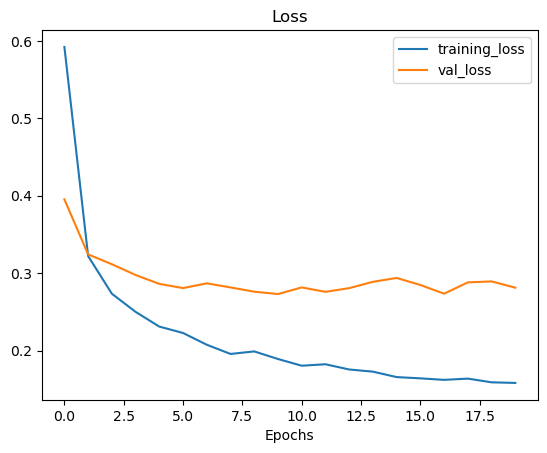

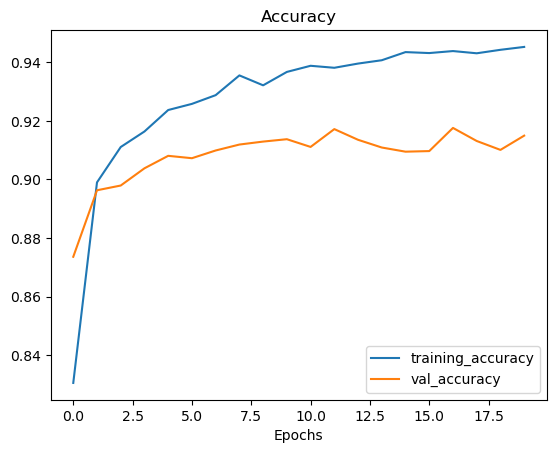

In [16]:
plot_loss_curves(history_mobileNet_fex)

## **Finetuning With MobileNetV2**

In [17]:
# Unfreeze all of the layers in base model
base_model.trainable=True

# Refreeze every layer except the last 5 layer 
for layer in base_model.layers[:-5]:
  layer.trainable=False

In [18]:
# What layers in the model are trainable?
for layer in model_mobileNet.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
mobilenetv2_1.00_224 True
global_avg_pooling_layer True
output_layer True


In [19]:
for layer_number, layer in enumerate(model_mobileNet.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 Conv1 False
2 bn_Conv1 False
3 Conv1_relu False
4 expanded_conv_depthwise False
5 expanded_conv_depthwise_BN False
6 expanded_conv_depthwise_relu False
7 expanded_conv_project False
8 expanded_conv_project_BN False
9 block_1_expand False
10 block_1_expand_BN False
11 block_1_expand_relu False
12 block_1_pad False
13 block_1_depthwise False
14 block_1_depthwise_BN False
15 block_1_depthwise_relu False
16 block_1_project False
17 block_1_project_BN False
18 block_2_expand False
19 block_2_expand_BN False
20 block_2_expand_relu False
21 block_2_depthwise False
22 block_2_depthwise_BN False
23 block_2_depthwise_relu False
24 block_2_project False
25 block_2_project_BN False
26 block_2_add False
27 block_3_expand False
28 block_3_expand_BN False
29 block_3_expand_relu False
30 block_3_pad False
31 block_3_depthwise False
32 block_3_depthwise_BN False
33 block_3_depthwise_relu False
34 block_3_project False
35 block_3_project_BN False
36 block_4_expand False
37 block_4_expa

## **Recompile and Evaluate The Model**

In [20]:
fine_tune_epochs = 25 # model has already done the 20 epochs (feature extraction), this is the total number of epochs we're after (20 + 5 =25)

# Fine-tune our model
history_mobileNet_fine_tune = model_mobileNet.fit(train_data,
                                            epochs=fine_tune_epochs, # fit to 5 epochs to keep experiment quick
                                            validation_data=test_data,
                                            validation_steps=int(0.15 * len(test_data)),
                                            initial_epoch=history_mobileNet_fex.epoch[-1])

Epoch 20/25


1237/1237 [==============================] - 879s 710ms/step - loss: 0.1577 - tp: 37084.0000 - fp: 1687.0000 - tn: 1422365.0000 - fn: 2473.0000 - accuracy: 0.9454 - precision: 0.9565 - recall: 0.9375 - auc: 0.9988 - val_loss: 0.5872 - val_tp: 589.0000 - val_fp: 101.0000 - val_tn: 26395.0000 - val_fn: 147.0000 - val_accuracy: 0.8193 - val_precision: 0.8536 - val_recall: 0.8003 - val_auc: 0.9857
Epoch 21/25
1237/1237 [==============================] - 876s 707ms/step - loss: 0.1537 - tp: 37170.0000 - fp: 1660.0000 - tn: 1422392.0000 - fn: 2387.0000 - accuracy: 0.9476 - precision: 0.9572 - recall: 0.9397 - auc: 0.9988 - val_loss: 0.6031 - val_tp: 592.0000 - val_fp: 104.0000 - val_tn: 26392.0000 - val_fn: 144.0000 - val_accuracy: 0.8152 - val_precision: 0.8506 - val_recall: 0.8043 - val_auc: 0.9863
Epoch 22/25
1237/1237 [==============================] - 879s 710ms/step - loss: 0.1552 - tp: 37132.0000 - fp: 1669.0000 - tn: 1422383.0000 - fn: 2425.0000 - accuracy: 0.9463 - precision: 0.9570

In [21]:
result_fine_tune_mobileNet = model_mobileNet.evaluate(test_data)
result_fine_tune_mobileNet

156/156 [==============================] - 106s 678ms/step - loss: 0.2752 - tp: 4535.0000 - fp: 333.0000 - tn: 179019.0000 - fn: 447.0000 - accuracy: 0.9187 - precision: 0.9316 - recall: 0.9103 - auc: 0.9947


[0.27516496181488037,
 4535.0,
 333.0,
 179019.0,
 447.0,
 0.9187073707580566,
 0.9315940737724304,
 0.9102770090103149,
 0.9946999549865723]

## **Compare Both Histories**

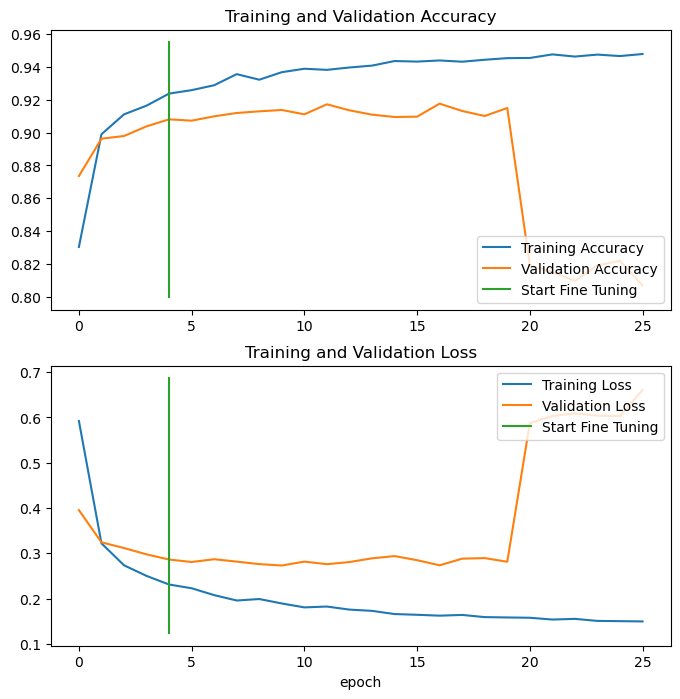

In [22]:
compare_historys(original_history=history_mobileNet_fex,
                 new_history=history_mobileNet_fine_tune,
                 initial_epochs=5)

## **Evaluate**

In [23]:
# Make predictions with model
preds_probs_mobileNet = model_mobileNet.predict(test_data, verbose=1) # set verbosity to see how long it left

156/156 [==============================] - 97s 613ms/step


In [24]:
# We get one prediction probability per class(in our case there's 101 prediction probabilities)
print(f"Number of prediction probabilites for sample 0: {len(preds_probs_mobileNet[0])}")
print(f"What prediction probabilites sample 0 looks like:\n {preds_probs_mobileNet[0]}")
print(f"The class with highest predicted probability by the model for sample 0: {preds_probs_mobileNet[0].argmax()}")


Number of prediction probabilites for sample 0: 37
What prediction probabilites sample 0 looks like:
 [9.98123705e-01 2.90315278e-04 2.01999792e-05 5.76733837e-05
 7.90615212e-11 3.35955032e-13 2.49213233e-10 7.12329362e-11
 7.53202906e-14 6.42301073e-11 4.33707423e-15 2.47621082e-15
 1.28947439e-12 1.52014124e-07 8.87757867e-09 1.70593495e-08
 2.57484658e-06 1.52213811e-10 8.38646656e-07 1.38209288e-09
 1.02462684e-16 4.53579282e-15 5.76549928e-06 9.52517287e-10
 3.51915446e-07 1.60359129e-10 6.19920729e-06 4.02966951e-04
 1.49187611e-06 3.62854689e-06 6.38572101e-06 6.41187398e-07
 1.81928833e-10 3.30205017e-04 3.14152345e-07 7.46381178e-04
 8.04904199e-11]
The class with highest predicted probability by the model for sample 0: 0


In [25]:
# Get the pred classes of each model
pred_classes_mobileNet = preds_probs_mobileNet.argmax(axis=1)

# How do they look like?
pred_classes_mobileNet[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [26]:
# To get our test dataset labels we need to unravel our test_data BatchDataset
y_labels_mobileNet = []
for images, labels in test_data.unbatch():
  y_labels_mobileNet.append(labels.numpy().argmax()) # currently test labels look like: [0, 0, 0, 1,.....0,0], we want the index value where the index value "1" occurs
y_labels_mobileNet[:10] # look at the first 10 

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [27]:
# The results from the saved model (Above) should be very similar to the results below
result_fine_tune_mobileNet

[0.27516496181488037,
 4535.0,
 333.0,
 179019.0,
 447.0,
 0.9187073707580566,
 0.9315940737724304,
 0.9102770090103149,
 0.9946999549865723]

In [28]:
# Get a list of class names
class_names =test_data.class_names
class_names[:10]

['Apple__black_rot',
 'Apple__healthy',
 'Apple__rust',
 'Apple__scab',
 'Cassava__bacterial_blight',
 'Cassava__brown_streak_disease',
 'Cassava__green_mottle',
 'Cassava__healthy',
 'Cassava__mosaic_disease',
 'Corn__common_rust']

In [29]:
import json
# Get a list of class names
class_names =test_data.class_names
class_names[:10]


# Save class_name_lookup as a JSON file
with open('mobileNet-class_names.json', 'w') as f:
    json.dump(class_names, f)

In [30]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# We need to make some changes to our make_confusion_matrix function to ensure the x-label print verticaly
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### changes (x-labels vertically) ###
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("mobilenet_confusion_matrix.png")

In [31]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.efficientnet import preprocess_input

input_image_path = "../../output_1/test/Tomato__septoria_leaf_spot/0745df82-cfd3-498c-add3-1a4d20f281b2___JR_Sept.L.S 8430.JPG"  

# Load and preprocess the input image
input_image = load_img(input_image_path, target_size=(224, 224))
input_image = img_to_array(input_image)
input_image = preprocess_input(input_image)
input_image = np.expand_dims(input_image, axis=0)  

predictions = model_mobileNet.predict(input_image)
predicted_class_index = np.argmax(predictions)
predicted_class = class_names[predicted_class_index] 

print(f'Predicted class: {predicted_class}')

1/1 [==============================] - 1s 1s/step
Predicted class: Tomato__target_spot


In [32]:
make_confusion_matrix(y_true=y_labels_mobileNet,
                       y_pred=pred_classes_mobileNet,
                       classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      savefig=True)

## **Classification Report of MobileNetV2**

In [33]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels_mobileNet,
                            y_pred=pred_classes_mobileNet))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        63
           1       0.97      0.99      0.98       166
           2       0.94      0.86      0.90        37
           3       0.94      0.89      0.91        70
           4       0.45      0.74      0.56        50
           5       0.71      0.30      0.42        57
           6       0.56      0.65      0.60        48
           7       0.57      0.45      0.50        69
           8       0.76      0.69      0.72        45
           9       0.98      0.97      0.97       132
          10       0.95      0.97      0.96       110
          11       1.00      0.98      0.99       117
          12       0.93      0.98      0.95       139
          13       1.00      0.99      0.99      1139
          14       0.98      0.96      0.97        47
          15       1.00      0.99      0.99        90
          16       0.97      1.00      0.98       231
          17       1.00    

In [34]:
# Get a dictionary of the classification report
classification_report_dict_mobileNet = classification_report(y_labels_mobileNet, pred_classes_mobileNet, output_dict=True)
classification_report_dict_mobileNet

{'0': {'precision': 0.9841269841269841,
  'recall': 0.9841269841269841,
  'f1-score': 0.9841269841269841,
  'support': 63.0},
 '1': {'precision': 0.9704142011834319,
  'recall': 0.9879518072289156,
  'f1-score': 0.9791044776119403,
  'support': 166.0},
 '2': {'precision': 0.9411764705882353,
  'recall': 0.8648648648648649,
  'f1-score': 0.9014084507042254,
  'support': 37.0},
 '3': {'precision': 0.9393939393939394,
  'recall': 0.8857142857142857,
  'f1-score': 0.9117647058823529,
  'support': 70.0},
 '4': {'precision': 0.45121951219512196,
  'recall': 0.74,
  'f1-score': 0.5606060606060607,
  'support': 50.0},
 '5': {'precision': 0.7083333333333334,
  'recall': 0.2982456140350877,
  'f1-score': 0.4197530864197531,
  'support': 57.0},
 '6': {'precision': 0.5636363636363636,
  'recall': 0.6458333333333334,
  'f1-score': 0.6019417475728155,
  'support': 48.0},
 '7': {'precision': 0.5740740740740741,
  'recall': 0.4492753623188406,
  'f1-score': 0.5040650406504064,
  'support': 69.0},
 '8'

In [35]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report dictionary items
for k, v in classification_report_dict_mobileNet.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
     # Add names and f1-scores to new dictionary
     class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores     


{'Apple__black_rot': 0.9841269841269841,
 'Apple__healthy': 0.9791044776119403,
 'Apple__rust': 0.9014084507042254,
 'Apple__scab': 0.9117647058823529,
 'Cassava__bacterial_blight': 0.5606060606060607,
 'Cassava__brown_streak_disease': 0.4197530864197531,
 'Cassava__green_mottle': 0.6019417475728155,
 'Cassava__healthy': 0.5040650406504064,
 'Cassava__mosaic_disease': 0.7209302325581395,
 'Corn__common_rust': 0.9733840304182511,
 'Corn__gray_leaf_spot': 0.9596412556053813,
 'Corn__healthy': 0.9913793103448275,
 'Grape__black_measles': 0.951048951048951,
 'Grape__black_rot': 0.9929453262786597,
 'Grape__healthy': 0.967741935483871,
 'Grape__leaf_blight_(isariopsis_leaf_spot)': 0.9944134078212291,
 'Peach__bacterial_spot': 0.982905982905983,
 'Peach__healthy': 0.9863013698630138,
 'Pepper_bell__bacterial_spot': 0.8869565217391304,
 'Pepper_bell__healthy': 0.9470404984423675,
 'Pomegranate__diseased': 0.8813559322033899,
 'Pomegranate__healthy': 0.8771929824561403,
 'Potato__early_blight'

In [36]:
# Turn f1 scores into Dataframe visualization
import pandas as pd
f1_scores =pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                        "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores       

,class_names,f1-score
26,Strawberry__healthy,1.000000
25,Strawberry___leaf_scorch,0.995516
15,Grape__leaf_blight_(isariopsis_leaf_spot),0.994413
13,Grape__black_rot,0.992945
11,Corn__healthy,0.991379
17,Peach__healthy,0.986301
0,Apple__black_rot,0.984127
16,Peach__bacterial_spot,0.982906
1,Apple__healthy,0.979104
36,Tomato__yellow_leaf_curl_virus,0.976303


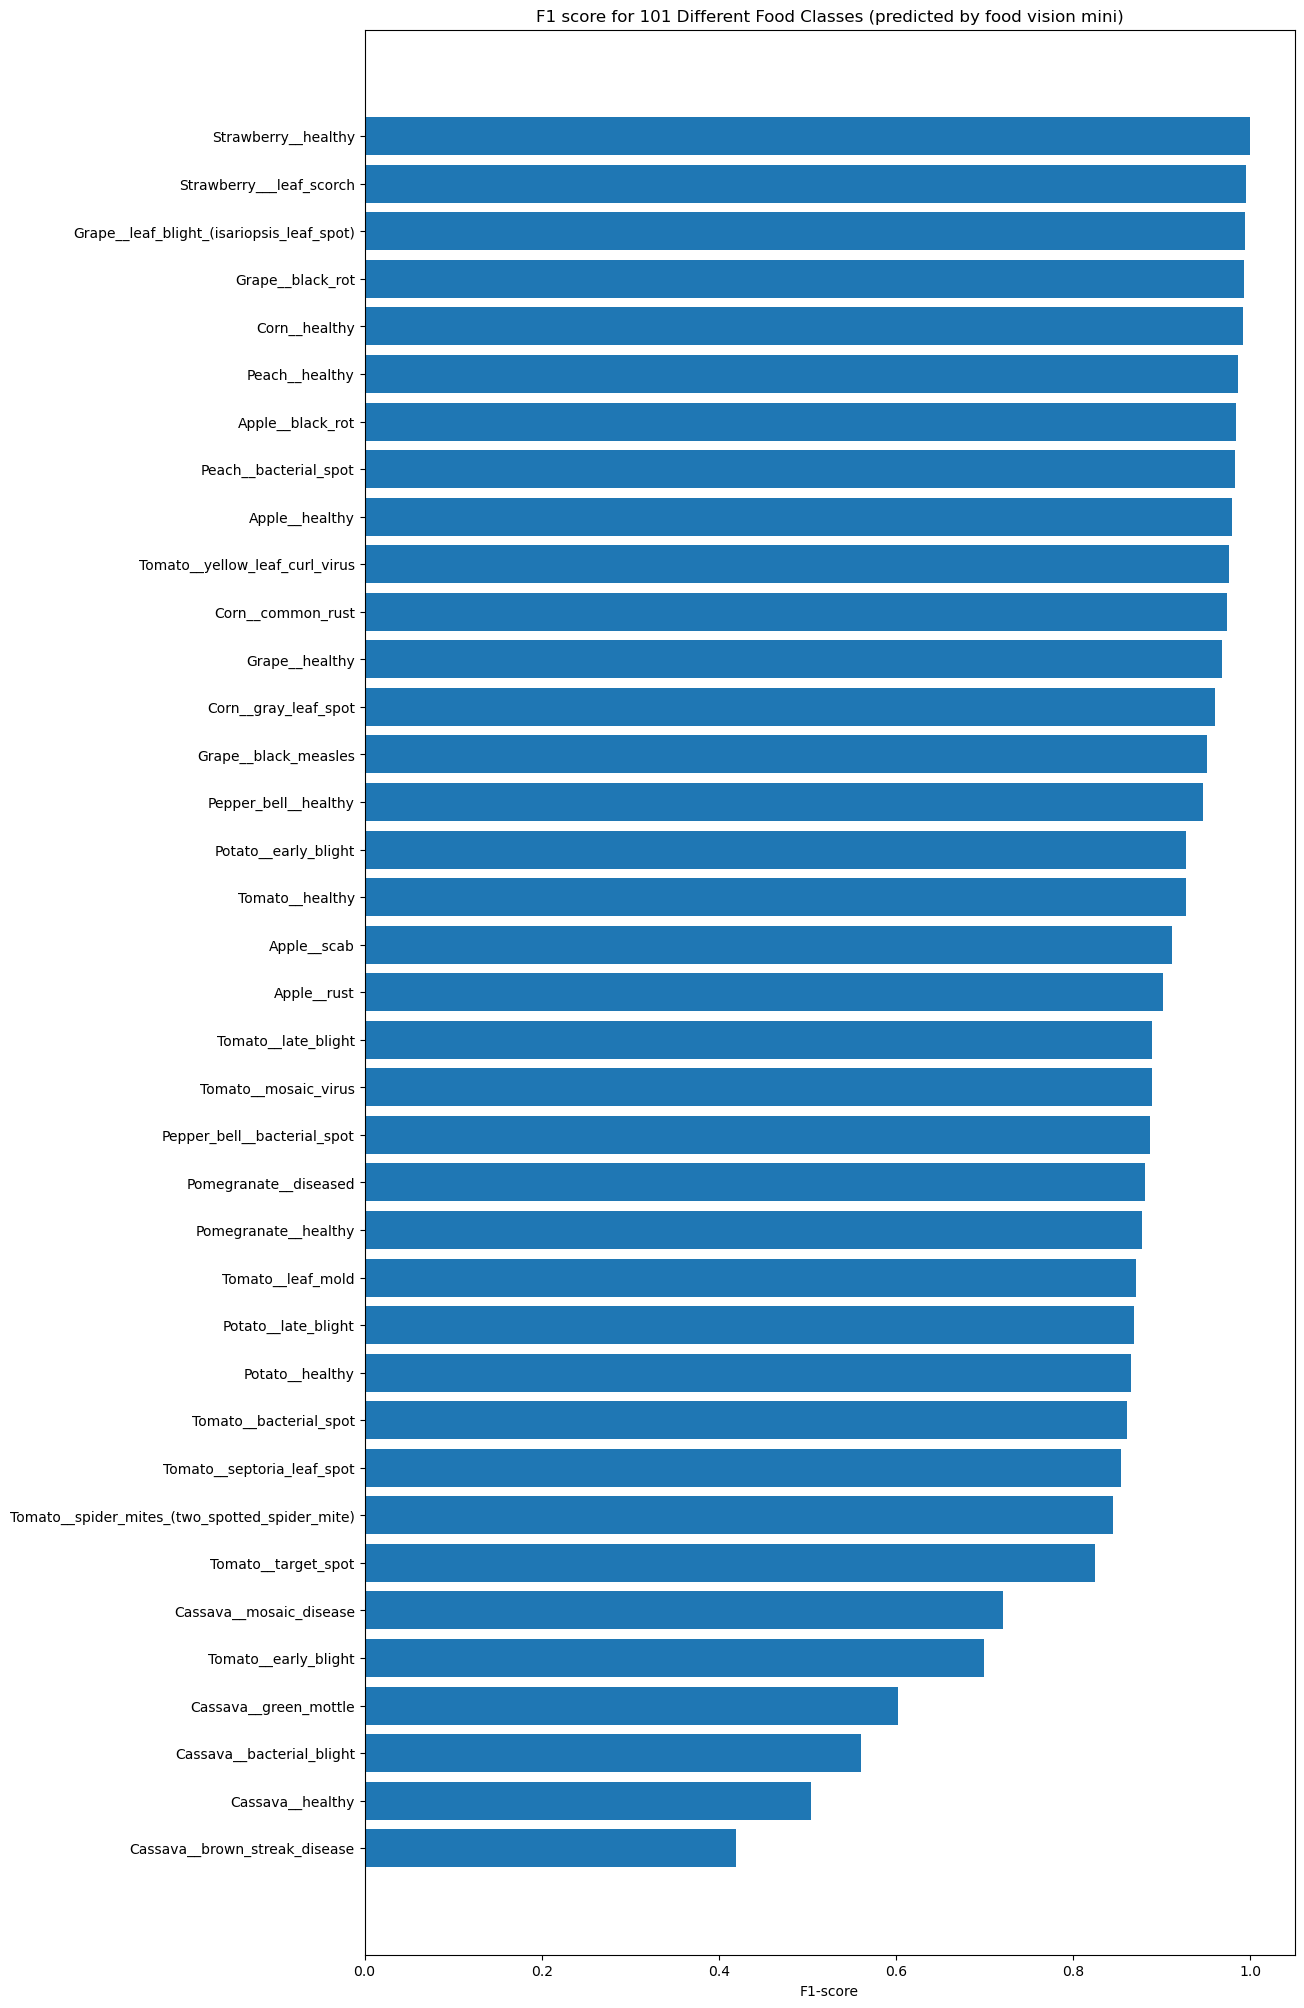

In [37]:
import matplotlib.pyplot as plt


import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values) # get f1-score value
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-score")
ax.set_title("F1 score for 101 Different Food Classes (predicted by food vision mini)")
ax.invert_yaxis(); # reverse the order of our plot

## **20-Saving and Loading The Model**

In [38]:
model_mobileNet.save('models/mobileNet.h5')

c:\Users\m7abu\anaconda3\envs\myenv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
